<a href="https://colab.research.google.com/github/wavemx/AI_project/blob/master/AIproject_091.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!wget https://mpp0xc0ae45ef.blob.core.windows.net/drivendata-mpp-storage/data/19/public/data-release.zip

!unzip -o data-release.zip

In [5]:
import pandas as pd
import numpy as np
from skimage.io import imread
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
%matplotlib inline

import keras
from keras import optimizers
from keras.utils import to_categorical
from keras.layers import Input, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.advanced_activations import ReLU

from keras import optimizers
from keras.optimizers import rmsprop
from keras import regularizers

from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

Using TensorFlow backend.


In [0]:

__author__ = 'Greg Gasowski'
__copyright__ = 'Copyright 2019, WaveMax LLC'
__credits__ = ['Greg Gasowski']
__license__ = 'MIT'
__version__ = '1.0'
__maintainer__ = 'Greg Gasowski'
__email__ = 'gregory.gasowski@gmail.com'
__status__ = 'Production'


In [7]:
train_df = pd.read_csv('train_labels.csv', index_col=0)

train_df['current_file'] = train_df.index.map(lambda id: f'train/{id}_c.png')
train_df['voltage_file'] = train_df.index.map(lambda id: f'train/{id}_v.png')

print(train_df.head())

      appliance      current_file      voltage_file
id                                                 
1000          4  train/1000_c.png  train/1000_v.png
1001          9  train/1001_c.png  train/1001_v.png
1002          4  train/1002_c.png  train/1002_v.png
1003          9  train/1003_c.png  train/1003_v.png
1004          6  train/1004_c.png  train/1004_v.png


Helper Function

In [0]:
def read_spectograms(file_paths, img_rows, img_cols, as_gray, channels):
  """
  Reads the spectogram files from disk and normalizes the pixel values
    @params:
      file_paths - Array of file paths to read from
      img_rows - The image height.
      img_cols - The image width.
      as_grey - Read the image as Greyscale or RGB.
      channels - Number of channels.
    @returns:
      The created and compiled model (Model)        
  """
  images = []
  
  for file_path in file_paths:
    images.append(imread(file_path, as_grey = as_gray))
  
  images = np.asarray(images, dtype=np.float32)
  
  # normalize
  images = images / np.max(images)
  
  # reshape to match Keras expectaions
  #images = images.reshape(images.shape[0], img_rows, img_cols, channels)
  images = images.reshape(images.shape[0], img_rows, img_cols, channels)

  return images

Parameters


In [0]:
as_gray = True
in_channel = 4

if as_gray:
  in_channel = 1

img_rows, img_cols = 128, 176
num_classes = 11 # number of appliances

batch_size = 32
epochs = 160
input_shape = (img_rows, img_cols, in_channel)
input_img = Input(shape = input_shape)

Current files


In [11]:
x_train_current = read_spectograms(train_df.current_file.values, img_rows, img_cols, as_gray, in_channel)

/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py:48: UserWarning: `as_grey` has been deprecated in favor of `as_gray`
  warn('`as_grey` has been deprecated in favor of `as_gray`')


Voltage files

In [12]:
x_train_voltage = read_spectograms(train_df.voltage_file.values, img_rows, img_cols, as_gray, in_channel)

/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py:48: UserWarning: `as_grey` has been deprecated in favor of `as_gray`
  warn('`as_grey` has been deprecated in favor of `as_gray`')


Labels


In [0]:
labels = train_df.appliance.values

# convert class vectors to binary class matrices One Hot Encoding
labels = keras.utils.to_categorical(labels, num_classes)

Show Data

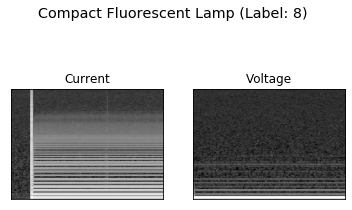

In [14]:
appliances = [
    'Heater',
    'Fridge', 
    'Hairdryer', 
    'Microwave', 
    'Air Conditioner',
    'Vacuum', 
    'Incandescent Light Bulb', 
    'Laptop', 
    'Compact Fluorescent Lamp',
    'Fan',
    'Washing Machine',
]

# pick a random index from the list
rn_appliance = np.random.choice(train_df.appliance.values)
rn_label = train_df.appliance.values[rn_appliance]
rn_current = x_train_current[rn_appliance]
rn_voltage = x_train_voltage[rn_appliance]

plt.figure()
plt.axis('off')

plt.suptitle(f"{appliances[rn_label]} (Label: {rn_label})", fontsize="x-large")

plt.subplot(121)
curr_img = None
if as_gray:
  curr_img = np.reshape(rn_current, (img_rows, img_cols))
else:
  curr_img = np.reshape(rn_current, (img_rows, img_cols, in_channel))

plt.imshow(curr_img, cmap='gray')
plt.title("Current")
plt.xticks([])
plt.yticks([])

plt.subplot(122)
if as_gray:
  curr_img = np.reshape(rn_voltage, (img_rows, img_cols))
else:
  curr_img = np.reshape(rn_voltage, (img_rows, img_cols, in_channel))

plt.imshow(curr_img, cmap='gray')
plt.title("Voltage")
plt.xticks([])
plt.yticks([])
plt.show()

Create and Train Model

Split in train and train batches

In [0]:
# stack so we can split on the same pair of images
x_train_comp = np.stack((x_train_current, x_train_voltage), axis=4)

x_train, x_test, y_train, y_test = train_test_split(x_train_comp, labels, test_size = 0.3, random_state=666)

# take them apart
x_train_current = x_train[:,:,:,:,0]
x_test_current = x_test[:,:,:,:,0]

x_train_voltage = x_train[:,:,:,:,1]
x_test_voltage = x_test[:,:,:,:,1]

Create the Model


In [0]:
def create_convolution_layers(input_img):
  #model = Conv2D(32, (3, 3), padding='same', input_shape=input_shape)(input_img)
  #model = LeakyReLU(alpha=0.1)(model)
  #model = MaxPooling2D((2, 2),padding='same')(model)
  #model = Dropout(0.25)(model)
  
  #model = Conv2D(64, (3, 3), padding='same')(model)
  #model = LeakyReLU(alpha=0.1)(model)
  #model = MaxPooling2D(pool_size=(2, 2),padding='same')(model)
  #model = Dropout(0.25)(model)
    
  #model = Conv2D(128, (3, 3), padding='same')(model)
  #model = LeakyReLU(alpha=0.1)(model)
  ##model = regularizers.l2(200) #add for test
  #model = MaxPooling2D(pool_size=(2, 2),padding='same')(model)
  #model = Dropout(0.4)(model)

  #model = Conv2D(512, (3, 3), padding='same')(model)
  #model = LeakyReLU(alpha=0.1)(model)
  #model = MaxPooling2D(pool_size=(2, 2),padding='same')(model)
  #model = Dropout(0.4)(model)

  model = Conv2D(32, (3, 3), padding='same', input_shape=input_shape)(input_img)
  model = ReLU()(model)
  model = MaxPooling2D((2, 2),padding='same')(model)
  model = Dropout(0.25)(model)
  
  model = Conv2D(64, (3, 3), padding='same')(model)
  model = ReLU()(model)
  model = MaxPooling2D(pool_size=(2, 2),padding='same')(model)
  model = Dropout(0.25)(model)
    
  model = Conv2D(128, (3, 3), padding='same')(model)
  model = ReLU()(model)
  model = MaxPooling2D(pool_size=(2, 2),padding='same')(model)
  model = Dropout(0.5)(model)

  #model = Conv2D(512, (3, 3), padding='same')(model)
  #model = ReLU()(model)
  #model = MaxPooling2D(pool_size=(2, 2),padding='same')(model)
  #model = Dropout(0.4)(model)

    
  return model

In [0]:
current_input = Input(shape=input_shape)
current_model = create_convolution_layers(current_input)

voltage_input = Input(shape=input_shape)
voltage_model = create_convolution_layers(voltage_input)

conv = concatenate([current_model, voltage_model])

conv = Flatten()(conv)

dense = Dense(512)(conv)
#dense = LeakyReLU(alpha=0.1)(dense)
dense = ReLU()(dense)
#kernel_regularizer=regularizers.l2(0.01)
dense = Dropout(0.9)(dense)

output = Dense(num_classes, activation='softmax')(dense)

model = Model(inputs=[current_input, voltage_input], outputs=[output])

opt = optimizers.Adam()
#sgd = SGD(lr=0.1, momentum=0.9)
#opt = optimizers.rmsprop()

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

print(model.summary())

Train Model

In [0]:
best_weights_file="w.best.hdf5"
checkpoint = ModelCheckpoint(best_weights_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
#lr_reducer = ReduceLROnPlateau(verbose=1)

callbacks = [checkpoint]

model.fit([x_train_current, x_train_voltage], y_train,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=callbacks,
          verbose=1,
          validation_data=([x_test_current, x_test_voltage], y_test),
          shuffle=True)

Basic Evaluation

In [0]:
# load weights
model.load_weights(best_weights_file)

final_loss, final_acc = model.evaluate([x_test_current, x_test_voltage], y_test, verbose=1)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))  

Predict


In [98]:
predict_df = pd.read_csv('submission_format.csv', index_col=0)

predict_df['current_file'] = predict_df.index.map(lambda id: f'test/{id}_c.png')
predict_df['voltage_file'] = predict_df.index.map(lambda id: f'test/{id}_v.png')

x_test_current = read_spectograms(predict_df.current_file.values, img_rows, img_cols, as_gray, in_channel)
x_test_voltage = read_spectograms(predict_df.voltage_file.values, img_rows, img_cols, as_gray, in_channel)

/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py:48: UserWarning: `as_grey` has been deprecated in favor of `as_gray`
  warn('`as_grey` has been deprecated in favor of `as_gray`')


In [0]:
#get the predictions for the test data
predicted_classes = model.predict([x_test_current, x_test_voltage])

predict_df.appliance = np.argmax(predicted_classes,axis=1)

predict_df = predict_df.drop(['current_file', 'voltage_file'], axis=1)

predict_df.to_csv('submission.csv')

from google.colab import files

files.download('submission.csv')